# TabNet을 활용한 베이스라인

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path
import pandas as pd
import random

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 로딩

In [3]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
test_file_path = os.path.join(data_dir, 'test_data.csv') 
df = pd.read_csv(csv_file_path)
test_df = pd.read_csv(test_file_path)
# df = pd.concat([df,test_df])

## 2. Feature Engineering

In [4]:
def elo_feature_engineering(df: pd.DataFrame):
    # item_elo = pd.read_csv(data_dir+'item_elo.csv',usecols=['assessmentItemID','beta'])
    # user_elo = pd.read_csv(data_dir+"user_elo.csv",usecols=['userID','theta'])
    # df = df.merge(item_elo,how='left',on='assessmentItemID')
    # df = df.merge(user_elo,how='left',on='userID')
    kt_item_elo = pd.read_csv(data_dir+'kt_item_elo.csv',usecols=['KnowledgeTag','beta'])
    kt_item_elo.columns = ['KnowledgeTag','kt_beta']
    kt_user_elo = pd.read_csv(data_dir+"kt_user_elo.csv",usecols=['userID','theta'])
    kt_user_elo.columns = ['userID','kt_theta']
    df = df.merge(kt_item_elo,how='left',on='KnowledgeTag')
    df = df.merge(kt_user_elo,how='left',on='userID')
    return df

In [5]:
def item_feature_engineering(df, test):
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']
    correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean','sum'])
    correct_a.columns = ["item_mean", 'item_sum']
    # time_a = df.groupby(['answerCode','assessmentItemID'])['elapsed'].agg(['median'])
    # time_a_0 = time_a.loc[0]
    # time_a_1 = time_a.loc[1]
    # time_a_0.columns = ['0_time_median']
    # time_a_1.columns = ['1_time_median']
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    # df = pd.merge(df, time_a_0, on=['assessmentItemID'], how="left")
    # df = pd.merge(df, time_a_1, on=['assessmentItemID'], how="left")
    test = pd.merge(test, correct_t, on=['testId'], how="left")
    test = pd.merge(test, correct_k, on=['KnowledgeTag'], how="left")
    test = pd.merge(test, correct_a, on=['assessmentItemID'], how="left")
    # test = pd.merge(test, time_a_0, on=['assessmentItemID'], how="left")
    # test = pd.merge(test, time_a_1, on=['assessmentItemID'], how="left")
    return df, test


In [6]:
def user_feature_engineering(df: pd.DataFrame):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['user_kt_answer'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['user_kt_total_answer'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['user_mean'] = df.groupby('userID')['answerCode'].transform(lambda x: x.mean())
    # correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    # correct_k.columns = ["tag_mean", 'tag_sum']
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용

    df['date'] = (df['Timestamp'].str[2]+df['Timestamp'].str[5:7]+df['Timestamp'].str[8:10]).astype(int)
    # df['category_2'] = df['assessmentItemID'].str[2].astype(int)
    # df['test_paper'] = df['assessmentItemID'].str[4:7].astype(int)
    # df['problem_id'] = df['assessmentItemID'].str[-3:].astype(int)

    # df = pd.merge(df, correct_t, on=['testId'], how="left")
    # df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    # df = pd.merge(df, correct_a, on=['assessmentItemID'], how='left')
    
    return df

In [7]:
def eta_process(df: pd.DataFrame):
    df['datetime'] = pd.to_datetime(df['Timestamp'])
    df['elapsed'] = df.groupby(['userID','testId'])['datetime'].transform(lambda x: x.diff().fillna(pd.Timedelta(seconds=0)))
    df['elapsed'] = df['elapsed'].apply(lambda x: x.total_seconds())
    df['elapsed_cumsum'] = df.groupby(['userID'])['elapsed'].cumsum()

In [8]:
def category2label(df: pd.DataFrame):
    global categorical_columns, categorical_dims
    categorical_columns = ['userID', 'assessmentItemID', 'KnowledgeTag','testId']
    categorical_dims = {}
    for col in categorical_columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = df[col].fillna("VV_likely") # 결측값 채우기, 얘는 뭐지?
        df[col] = l_enc.fit_transform(df[col].values) # 정수값으로 인코딩(수치화)
        categorical_dims[col] = len(l_enc.classes_)

In [9]:
eta_process(df)
eta_process(test_df)

In [10]:
df = user_feature_engineering(df)
test_df = user_feature_engineering(test_df)
df, test_df = item_feature_engineering(df,test_df)
df.fillna(0,inplace=True)
test_df.fillna(0,inplace=True)
test_uid = set(test_df.userID.unique())
df = pd.concat([df,test_df])
df = elo_feature_engineering(df)
category2label(df)
test_df = df[df['userID'].isin(test_uid)]
df = df[~df['userID'].isin(test_uid)]
df.head()

userID 7442
assessmentItemID 9454
KnowledgeTag 912
testId 1537


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,datetime,elapsed,elapsed_cumsum,user_correct_answer,...,user_mean,date,test_mean,test_sum,tag_mean,tag_sum,item_mean,item_sum,kt_beta,kt_theta
0,0,5354,975,1,2020-03-24 00:17:11,556,2020-03-24 00:17:11,0.0,0.0,0.0,...,0.630872,20324,0.947683,1268,0.955022,637,0.982063,219,-2.981654,0.35437
1,0,5355,975,1,2020-03-24 00:17:14,557,2020-03-24 00:17:14,3.0,3.0,1.0,...,0.630872,20324,0.947683,1268,0.913187,3040,0.964126,215,-2.262750,0.35437
2,0,5356,975,1,2020-03-24 00:17:22,557,2020-03-24 00:17:22,8.0,11.0,2.0,...,0.630872,20324,0.947683,1268,0.913187,3040,0.910314,203,-2.262750,0.35437
3,0,5357,975,1,2020-03-24 00:17:29,557,2020-03-24 00:17:29,7.0,18.0,3.0,...,0.630872,20324,0.947683,1268,0.913187,3040,0.968610,216,-2.262750,0.35437
4,0,5358,975,1,2020-03-24 00:17:36,557,2020-03-24 00:17:36,7.0,25.0,4.0,...,0.630872,20324,0.947683,1268,0.913187,3040,0.941704,210,-2.262750,0.35437


In [11]:
test = test_df[test_df['answerCode'] == -1]
valid = test_df[test_df['answerCode'] != -1]

## 3. Train/Valid 데이터 셋 분리

In [12]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_valid_split(df, split=True):
    #test데이터셋은 각 유저의 마지막 interaction만 추출
    train = df[df['userID'] == df['userID'].shift(-1)]
    valid = df[df['userID'] != df['userID'].shift(-1)]
    return train, valid

In [13]:
valid_last = valid[valid['userID'] != valid['userID'].shift(-1)]
#valid = valid[valid['userID'] == valid['userID'].shift(-1)]

In [14]:
# 유저별 분리
#train, valid = custom_train_valid_split(train)

# 사용할 Feature 설정
train = df
# train = pd.concat([df,valid])

In [15]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'datetime', 'elapsed', 'elapsed_cumsum',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'user_kt_answer', 'user_kt_total_answer', 'user_mean', 'date',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'item_mean', 'item_sum',
       'kt_beta', 'kt_theta'],
      dtype='object')

In [16]:
unused_feat = ['Set','Timestamp','datetime','userID','user_mean']
categorical_columns = ['assessmentItemId','KnowledgeTag','testId']#,'userID']
target = 'answerCode'

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [17]:
# X, y 값 분리
X_train = train[features].values
y_train = train[target].values

X_valid = valid[features].values
y_valid = valid[target].values

X_valid_last = valid_last[features].values
y_valid_last = valid_last[target].values


X_test = test[features].values

In [18]:
features

['assessmentItemID',
 'testId',
 'KnowledgeTag',
 'elapsed',
 'elapsed_cumsum',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'user_kt_answer',
 'user_kt_total_answer',
 'date',
 'test_mean',
 'test_sum',
 'tag_mean',
 'tag_sum',
 'item_mean',
 'item_sum',
 'kt_beta',
 'kt_theta']

In [34]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":10,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=0.01),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                    "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "device_name": 'cuda',
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [35]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [36]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid_last, y_valid_last),(X_valid, y_valid),],
    eval_name=['valid_last','valid',],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=8,
    batch_size=16384, virtual_batch_size=256,
    num_workers=4,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 0.57399 | valid_last_auc: 0.56164 | valid_auc: 0.58077 |  0:00:28s
epoch 1  | loss: 0.52338 | valid_last_auc: 0.80613 | valid_auc: 0.76932 |  0:00:55s
epoch 2  | loss: 0.51651 | valid_last_auc: 0.83316 | valid_auc: 0.81572 |  0:01:24s
epoch 3  | loss: 0.5145  | valid_last_auc: 0.83168 | valid_auc: 0.82239 |  0:01:51s
epoch 4  | loss: 0.51484 | valid_last_auc: 0.82886 | valid_auc: 0.82326 |  0:02:19s
epoch 5  | loss: 0.51309 | valid_last_auc: 0.82992 | valid_auc: 0.82345 |  0:02:48s
epoch 6  | loss: 0.51218 | valid_last_auc: 0.82989 | valid_auc: 0.82434 |  0:03:15s
epoch 7  | loss: 0.51157 | valid_last_auc: 0.82976 | valid_auc: 0.82465 |  0:03:43s
epoch 8  | loss: 0.51084 | valid_last_auc: 0.82758 | valid_auc: 0.82488 |  0:04:11s
epoch 9  | loss: 0.51062 | valid_last_auc: 0.82837 | valid_auc: 0.82483 |  0:04:39s
epoch 10 | loss: 0.50914 | valid_last_auc: 0.82702 | valid_auc: 0.82486 |  0:05:07s
epoch 11 | loss: 0.50892 | valid_last_auc: 0.82925 | valid_auc: 0.82541 |  0

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


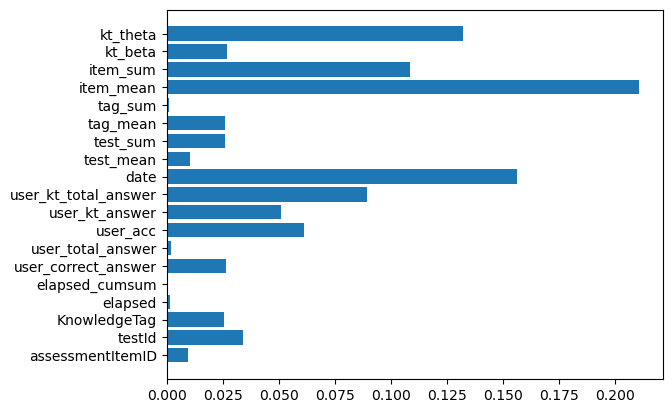

In [22]:
# best_valid_last_auc = 0.83316 valid_auc: 0.81572
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

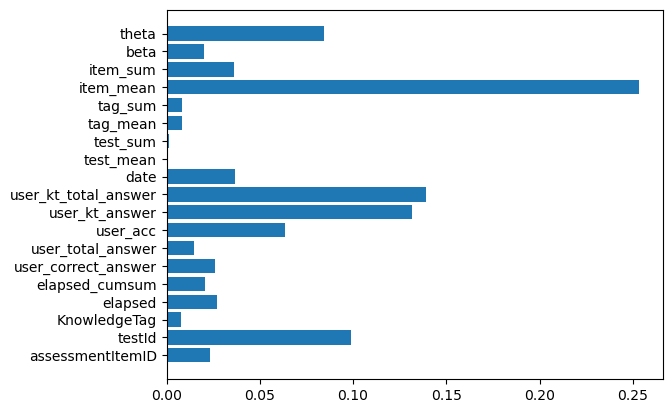

In [88]:
# using test data as valid set with item mean(valid_last_score=0.83108 at 10th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

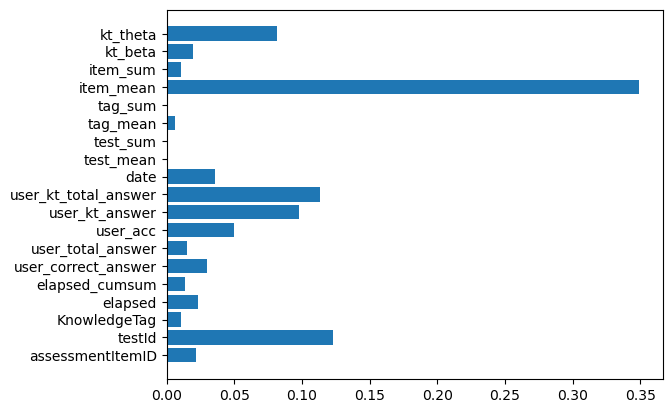

In [62]:
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

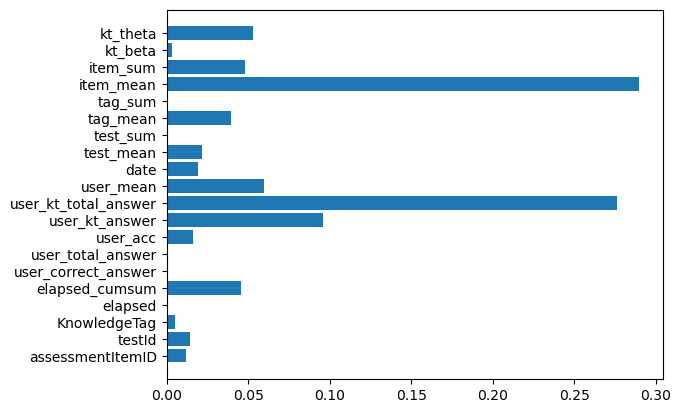

In [44]:
# added user mean
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

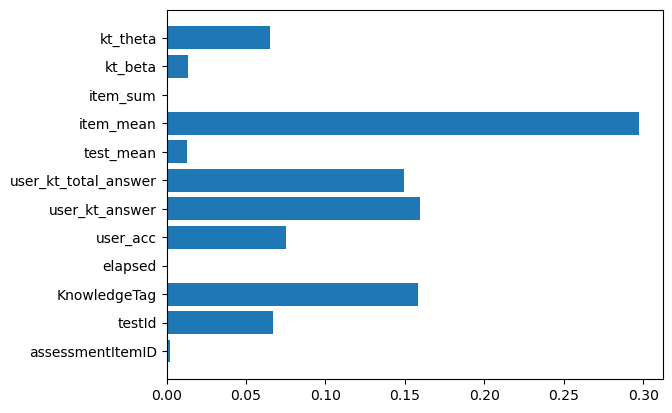

In [122]:
# with item elo score 0.83283
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

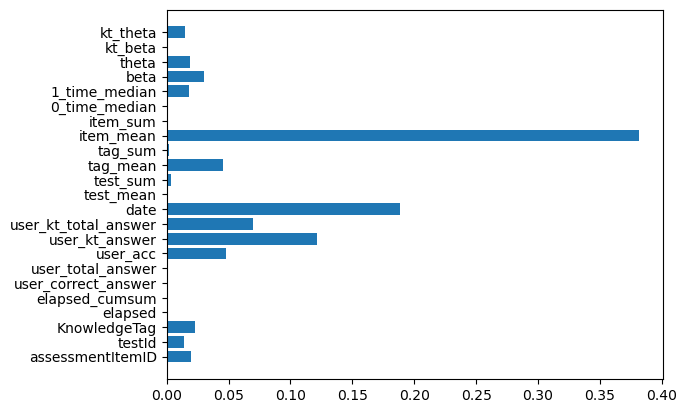

In [109]:
# with item elo score 0.83502
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

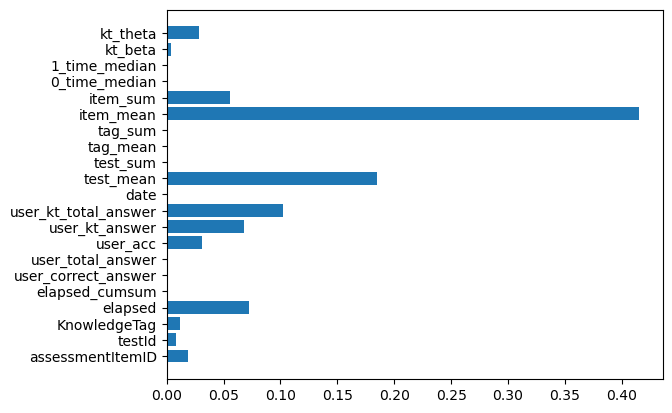

In [86]:
# without item elo score 0.83794
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

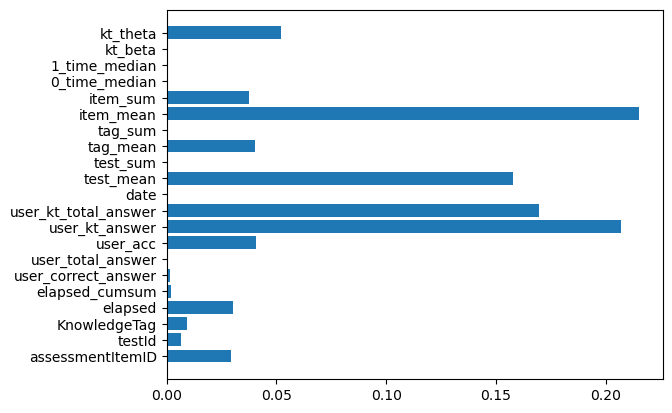

In [65]:
x = np.arange(len(features))# 0.8351
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

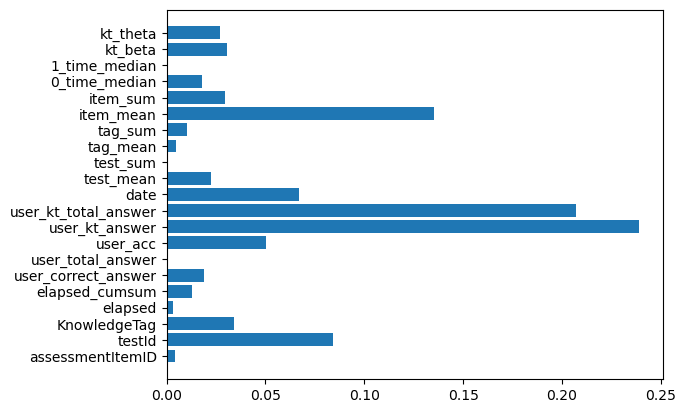

In [27]:
#lr=0.01 using test data as valid set with item mean and elapse median(valid_last_score=0.83007 at 18th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

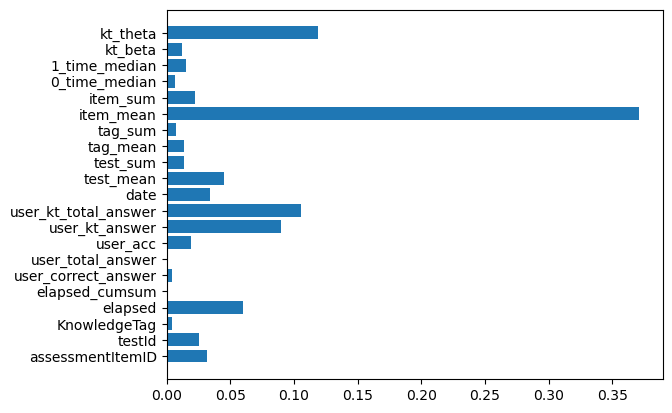

In [23]:
#lr=0.01 using test data as valid set with item mean and elapse median(valid_last_score=0.83007 at 18th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

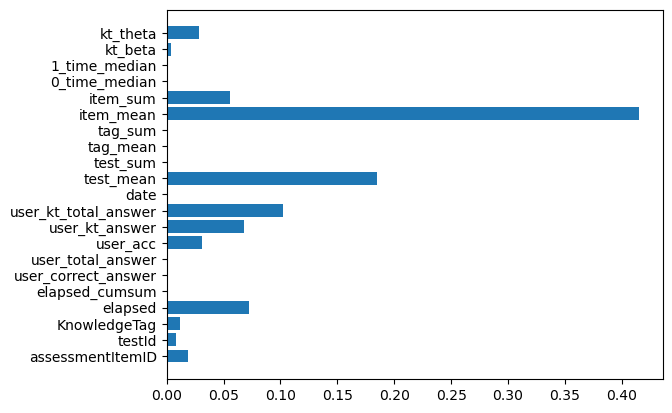

In [19]:
# using test data as valid set with item mean and elapse median(valid_last_score=0.83365 at 25th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

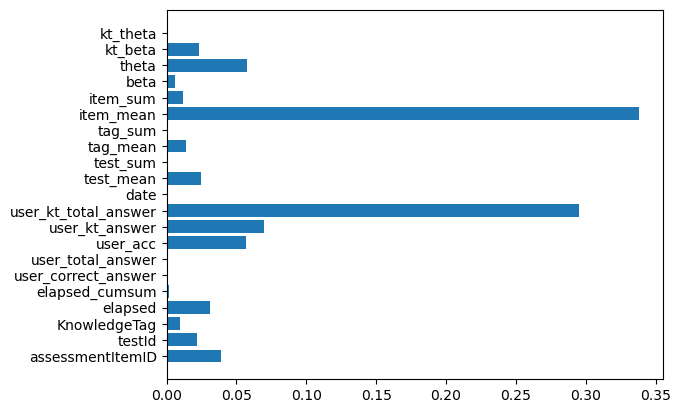

In [21]:
# using test data as valid set with assessmentItem elo rating(valid_last_score= at 10th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

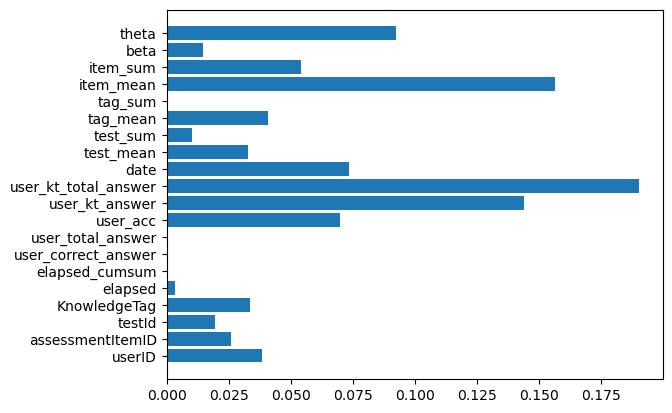

In [98]:
# using test data as valid set with item mean with userID(valid_last_score=0.83109 at 10th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

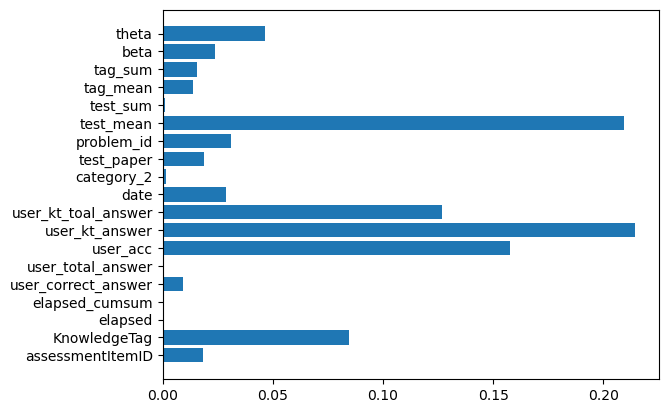

In [57]:
# using test data as valid set with eta and eta_cumsum and elo rating(valid_score=0.81520 at 49th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

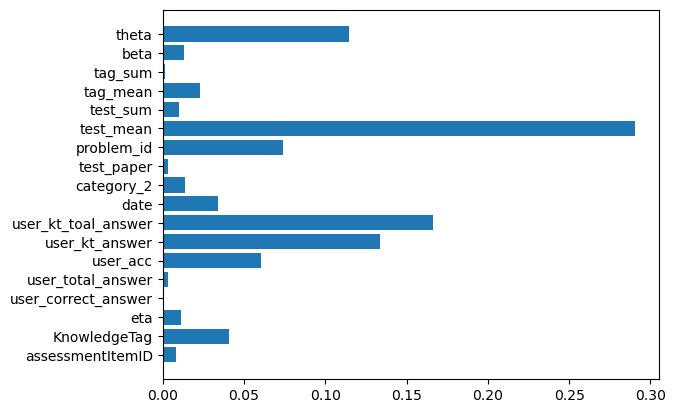

In [33]:
# using test data as valid set with eta and elo rating(valid_score=0.81349 at 40th epoch)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

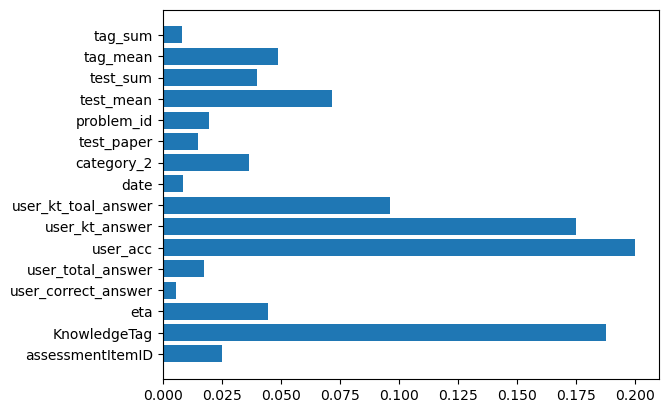

In [212]:
# using test data as valid set with eta (valid_score 0.8063)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

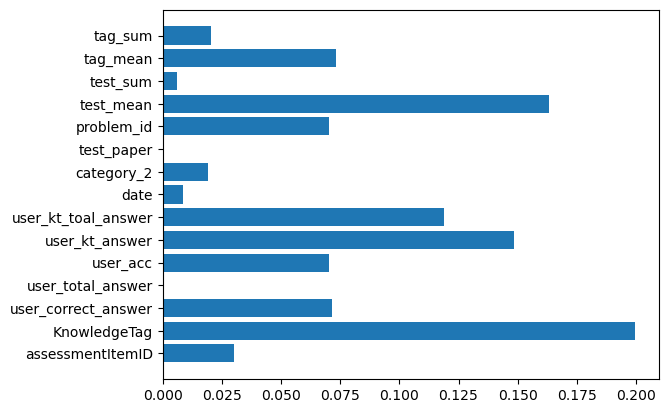

In [141]:
# using test data as valid set. valid score is 0.80617(tab_submission_noeta_0.80617)
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

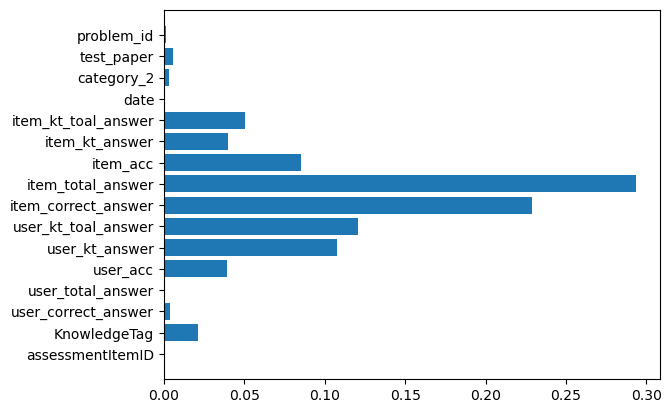

In [110]:
# not using Data Leakage Feature and no UserID 0.7929
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

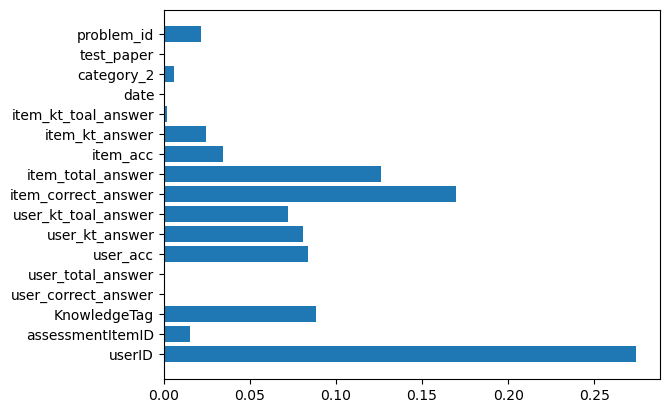

In [96]:
# not using Data Leakage Feature with UserID
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

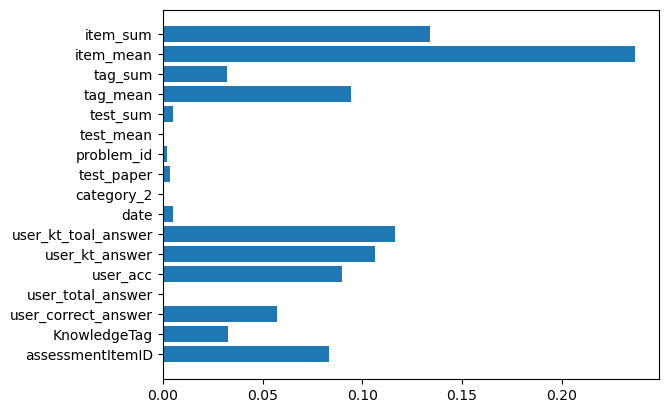

In [67]:
# no UserID
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

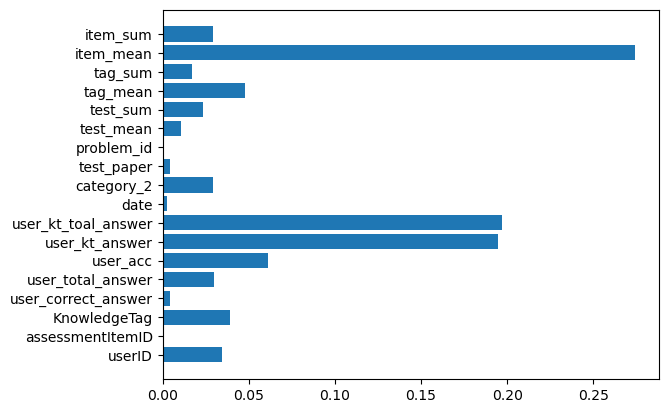

In [35]:
# using UserID
x = np.arange(len(features))
plt.barh(x, clf.feature_importances_)
plt.yticks(x, features)
plt.show()

In [37]:
preds = clf.predict_proba(X_test)

In [38]:
result = pd.DataFrame(preds[:,1]).reset_index()
result.columns = ['id','prediction']
result

,id,prediction
0,0,0.400907
1,1,0.611632
2,2,0.142724
3,3,0.611109
4,4,0.171508
...,...,...
739,739,0.010471
740,740,0.530436
741,741,0.717397
742,742,0.680846


In [39]:
result.to_csv('output/tab_submission.csv',index=False)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [ ]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [ ]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

